In [ ]:
from datetime import datetime
from matplotlib import pyplot as plt
import multiprocessing as mp
import numpy as np

import vip_hci as vip
from hciplot import plot_frames, plot_cubes
from vip_hci.fits import open_fits
from vip_hci.fm import cube_planet_free, firstguess, normalize_psf
from vip_hci.metrics import completeness_curve, contrast_curve, detection, \
    inverse_stim_map, significance, snr, snrmap, stim_map, throughput
from vip_hci.psfsub import median_sub, pca, pca_annular
from vip_hci.preproc import find_scal_vector, frame_rescaling
from vip_hci.var import frame_center, mask_circle

import redux_utils

In [ ]:
channel_min = 45
channel_max = 74
channel_nums = list(range(channel_min, channel_max + 1))
angles_path = "data/parangs_bads_removed.txt"
wavelengths_path = "data/channel_wavelengths.txt"
data_dir = "./data/005_center_multishift/"
data_name = "wl_channel_%05i.fits"
data_paths = [data_dir + data_name%num for num in channel_nums]

In [ ]:
angles, wavelengths = redux_utils.init(angles_path, wavelengths_path, channels=channel_nums)

cube_list = []
for path in data_paths:
    cube_list.append(open_fits(path, verbose=False))
cube = np.array(cube_list)

n_channels = cube.shape[0]
n_frames = cube.shape[1]
frame_shape = cube.shape[-2:]

In [ ]:
print(angles.shape)
print(wavelengths.shape)
print(cube.shape)

(2202,)
(30,)
(30, 2202, 63, 63)


In [ ]:
cube_skip = cube[:, ::redux_utils.everynthframe]
angles_skip = angles[::redux_utils.everynthframe]

cube = cube_skip
angles = angles_skip

n_frames = len(angles)

In [ ]:
# model psf - take median along time axis - beware of companion smearing/self-sub
psf = np.median(cube_skip, axis=1)

In [ ]:
# get flux and fwhm of host star in each channel
psfn, flux_st, fwhm_list = normalize_psf(psf, fwhm="fit", full_output=True, debug=False)

Mean FWHM per channel: 
[3.106 3.112 3.127 3.14  3.131 3.14  3.158 3.171 3.167 3.182 3.194 3.199
 3.203 3.218 3.224 3.233 3.237 3.258 3.262 3.275 3.296 3.322 3.338 3.342
 3.345 3.37  3.388 3.381 3.414 3.407]
Flux in 1xFWHM aperture: 
[18062.941 18424.468 18887.383 19598.522 20232.566 20633.197 20614.565
 20336.509 19942.662 19654.25  19142.203 18432.716 17529.875 17043.853
 16675.724 16619.507 16324.134 15818.503 14733.646 13598.693 12587.187
 11973.875 11776.553 11861.696 12196.421 12559.831 12797.467 12835.802
 12800.905 12389.608]


In [ ]:
#pixel diameter of star
mask_rad = 10
mask = mask_circle(np.ones_like(cube[0,0]), mask_rad)

#iterate over wavelength channels to find opt spatial- and flux-scaling factors for each
time_cubes = [cube[:, i] for i in range(n_frames)]
input_list = list(zip(time_cubes, np.repeat([wavelengths], n_frames, axis=0), 
             np.repeat([flux_st], n_frames, axis=0), np.repeat([mask], n_frames, axis=0),
             np.repeat([2], n_frames), np.repeat(["stddev"], n_frames)))

In [ ]:
be_slow = False

if be_slow:
    tstart = datetime.now()
    print(tstart)
    with mp.Pool(redux_utils.numworkers) as pool:
        output = np.array(pool.starmap(find_scal_vector, input_list, chunksize=redux_utils.chunksize))
    tend = datetime.now()
    print(tend)
    dt = tend - tstart
    print(dt)

    opt_scal = np.median(output[:,0], axis=0)
    opt_flux = np.median(output[:,1], axis=0)

    # only good in slow case - use if plotting residuals
    # opt_scals = output[:,0]
    # opt_fluxes = output[:,1]
    # res_scaling = np.zeros_like(cube[:,0,:,:])
    # for i in range(n_channels):
    #     res_scaling[i] = opt_fluxes[0, i] * frame_rescaling(cube[i, 0], scale=opt_scal[i]) - cube[-1, 0]
else:
    opt_scal, opt_flux = find_scal_vector(np.mean(cube, axis=1), wavelengths, flux_st, mask=mask, nfp=2, fm="stddev")

In [ ]:
# pp and analysis consts/args
ncomp = redux_utils.numcomps
nproc = redux_utils.numworkers
nbranch = 2
pxscale = 0.027
drot = 0.5
an_dist = np.linspace(np.min(angles), np.max(angles), nbranch, endpoint=True)
algo = pca
algo_dict = {'ncomp': ncomp, 'imlib': 'opencv'}
rot_options = {'mask_val': 0, 'interp_zeros': True, 'imlib': 'vip-fft', 'interpolation': 'lanczos4'}

In [ ]:
# Classical ASDI
imlib = 'vip-fft'
interpolation = 'lanczos4'
med_asdi = median_sub(cube, angles, scale_list=opt_scal, flux_sc_list=opt_flux,
                      radius_int=mask_rad, interpolation=interpolation, nproc=nproc)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-07-11 14:42:42
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
30 spectral channels per IFS frame
First median subtraction exploiting spectral variability
Running time:  0:00:23.812010
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
111 ADI frames
Median subtraction in the ADI fashion
Done derotating and combining
Running time:  0:00:24.113642
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


In [ ]:
pl_loc = (12, 41)
st_loc = frame_center(cube)
pl_rad = np.sqrt(np.sum(np.square(np.array(st_loc) - np.array(pl_loc))))
fwhm = np.mean(fwhm_list)
pl_snr = snr(med_asdi, pl_loc, fwhm=fwhm, exclude_negative_lobes=True)
pl_sgn = significance(pl_snr, pl_rad, fwhm, student_to_gauss=True)
print(pl_snr, pl_sgn)

13.423041555884483 8.209536151601387


In [ ]:
plt.imshow(med_asdi)
plt.title("HD 1160 B Detection\nMedian-ASDI")
plt.text(0.6, 0.9, "snr: %.1f = %.1f$\sigma$"%(pl_snr, pl_sgn),
         transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='#f5f5dc', alpha=0.5))
plt.tight_layout()
plt.savefig("med_asdi.png")
plt.close()

In [16]:
# Full-frame PCA-ASDI
# Single step
pca_asdi = pca(cube, angles, scale_list=opt_scal, ncomp=ncomp, 
               adimsdi="single", crop_ifs=False, mask_center_px=mask_rad,
               scaling="temp-standard", nproc=nproc, full_output=False, **rot_options)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-07-11 14:52:59
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
System total memory = 15.971 GB
System available memory = 4.792 GB
Rescaling the spectral channels to align the speckles
Running time:  0:01:11.278000
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
3330 total frames
Performing single-pass PCA
Done vectorizing the frames. Matrix shape: (3330, 64009)
Done SVD/PCA with numpy SVD (LAPACK)
Running time:  0:03:03.933445
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Descaling the spectral channels
De-rotating and combining residuals
Running time:  0:03:22.302599
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


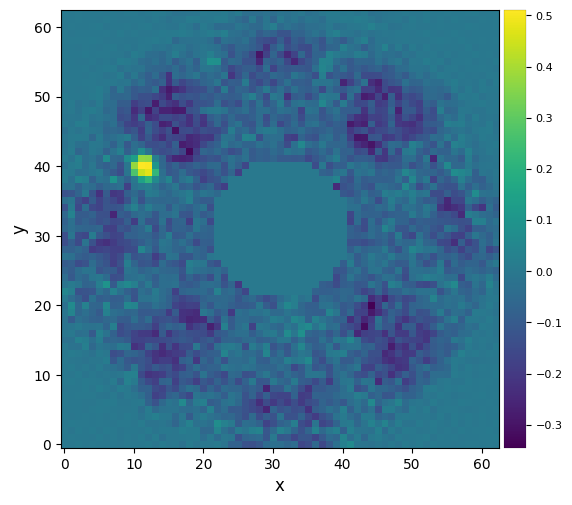

In [17]:
plot_frames(pca_asdi, colorbar=True)
# analysis.calc_stats(pca_asdi, fwhm_mean)

In [19]:
# Double step
pca_asdi_dbl = pca(cube, angles, scale_list=opt_scal, ncomp=(redux_utils.numcomps, redux_utils.numcomps),
                   adimsdi="double", crop_ifs=False, mask_center_px=mask_rad,
                   interpolation=interpolation, scaling="temp-standard", nproc=redux_utils.numworkers,
                   full_output=False, **rot_options)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-07-11 14:58:26
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
System total memory = 15.971 GB
System available memory = 8.882 GB
30 spectral channels in IFS cube
First PCA stage exploiting spectral variability
Running time:  0:00:26.056070
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
111 ADI frames
Second PCA stage exploiting rotational variability
De-rotating and combining residuals
Running time:  0:00:26.603100
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


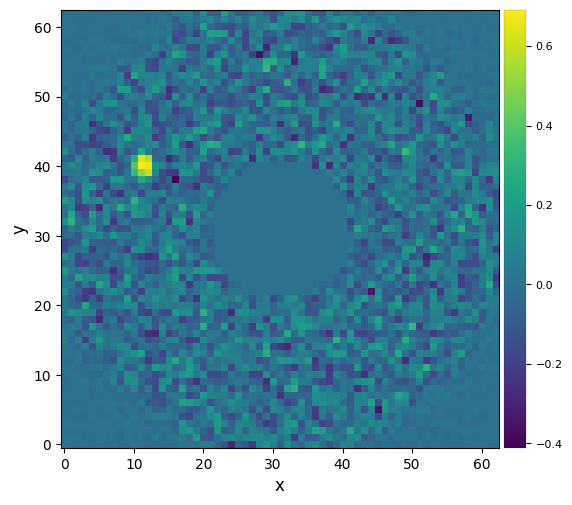

In [20]:
plot_frames(pca_asdi_dbl, colorbar=True)
# analysis.calc_stats(pca, fwhm_mean)

In [26]:
# Annular PCA-ASDI
# Double step
pca_res, pca_res_der, pca_asdi_dbl = pca_annular(cube, angles, scale_list=opt_scal, ncomp=(ncomp, ncomp),
                   radius_int=mask_rad, asize=fwhm, fwhm=fwhm, nproc=nproc, full_output=True, **rot_options)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-07-11 15:04:45
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
First PCA subtraction exploiting the spectral variability
30 spectral channels per IFS frame
N annuli = 6, mean FWHM = 3.000
Running time:  0:00:23.278396
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
111 ADI frames
Second PCA subtraction exploiting the angular variability
N annuli = 6, FWHM = 3.000
PCA per annulus (or annular sectors):
Ann 1    PA thresh:  1.48    Ann center:  12    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:23.452552
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 2    PA thresh:  3.24    Ann center:  15    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:23.625596
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

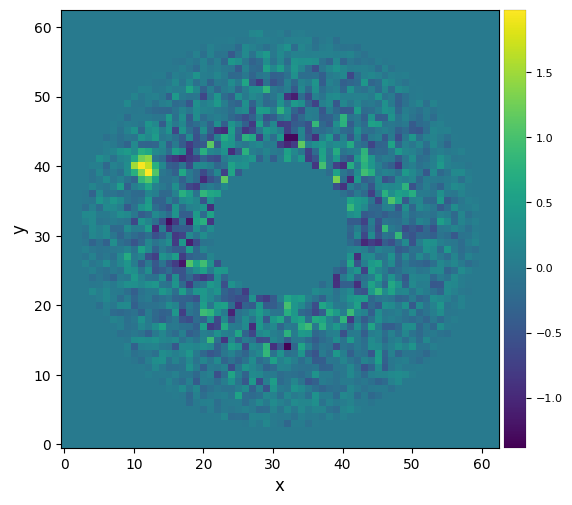

In [27]:
plot_frames(pca_asdi_dbl, colorbar=True)
# analysis.calc_stats(pca, fwhm_mean)

In [ ]:
# analysis stuff seems to require 3D cubes to work with

In [94]:
# post-processed data cube
pp_cube = pca_asdi_dbl

pl_loc_channel = 0
cube_sel_chnl = cube[pl_loc_channel]
psfn_sel_chnl = psfn[pl_loc_channel]

In [95]:
# analysis
annulus_width = 4 # random
aperture_radius = 1 # random


pl_rad, pl_theta, pl_flux = firstguess(cube_sel_chnl, angles, psfn_sel_chnl, ncomp, [pl_loc], fwhm=fwhm, annulus_width=annulus_width, aperture_radius=aperture_radius, simplex=True, plot=True, verbose=True)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-07-11 16:18:22
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
             Planet 0           
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

Planet 0: flux estimation at the position [12,41], running ...
Step | flux    | chi2r
1/30   0.100   0.954
2/30   0.149   0.952
3/30   0.221   0.950
4/30   0.329   0.947
5/30   0.489   0.942
6/30   0.728   0.934
7/30   1.083   0.923
8/30   1.610   0.908
9/30   2.395   0.886
10/30   3.562   0.854
11/30   5.298   0.807
12/30   7.880   0.743
13/30   11.721   0.656
14/30   17.433   0.556
15/30   25.929   0.456
16/30   38.566   0.414
17/30   57.362   0.599
18/30   85.317   1.370
19/30   126.896   3.329


/home/v1aatki4/.conda/envs/astro/lib/python3.9/site-packages/vip_hci/fm/negfc_simplex.py:224: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


Planet 0: preliminary position guess: (r, theta)=(21.5, 152.2)
Planet 0: preliminary flux guess: 38.6
Planet 0: Simplex Nelder-Mead minimization, running ...
Planet 0: Success: True, nit: 98, nfev: 210, chi2r: 0.15534646944566208
message: Optimization terminated successfully.
Planet 0: simplex result: (r, theta, f)=(21.507, 154.779, 44.988) at 
          (X,Y)=(11.54, 40.16)

 ―――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――― 
DONE !
 ――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running time:  0:02:59.879529
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


[359.02225719          nan] 21.470910553583888
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-07-11 16:13:27
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


/tmp/ipykernel_520970/2940157015.py:7: RuntimeWarning: invalid value encountered in arccos
  pl_theta = np.arccos((pl_loc[0], c_loc[0]) / pl_rad)
/home/v1aatki4/.conda/envs/astro/lib/python3.9/site-packages/vip_hci/metrics/snr_source.py:448: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
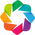

S/N map created using 6 processes
Running time:  0:00:00.990631
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


In [78]:
c_loc = frame_center(cube[0,0])

# pl_loc = c_loc + pl_rad * np.array([np.cos(pl_theta * np.pi / 180), np.sin(pl_theta * np.pi / 180)])
# pl_loc = tuple(pl_loc[0])
pl_loc = (12, 41)
pl_rad = np.sqrt(np.sum(np.power(np.subtract(pl_loc, c_loc), 2)))
pl_theta = np.arccos((pl_loc[0], c_loc[0]) / pl_rad)
if pl_loc[0] < c_loc[0]:
    pl_theta = 360 - pl_theta

pl_snr = snr(pp_cube, pl_loc, fwhm=fwhm, exclude_negative_lobes=True, plot=True)
pl_sgn = significance(pl_snr, pl_rad, fwhm, student_to_gauss=True)
pl_snrmap = snrmap(pp_cube, fwhm, plot=True, approximated=False, backend='bokeh')

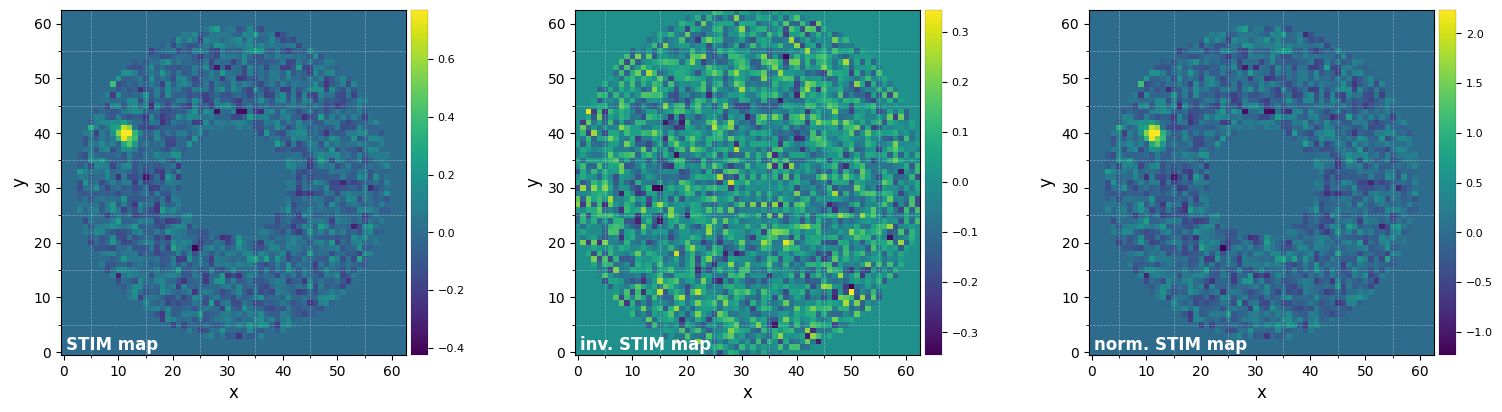

In [34]:
# pca w/ full output must be done for stim map w/ normalization
pl_stimmap = stim_map(pca_res_der)
pl_stimmap_inv = inverse_stim_map(pca_res, angles)
pl_stimmap_norm = pl_stimmap / np.nanmax(pl_stimmap_inv)

plot_frames((pl_stimmap, pl_stimmap_inv, pl_stimmap_norm), grid=True,
            label=('STIM map', 'inv. STIM map', 'norm. STIM map'))

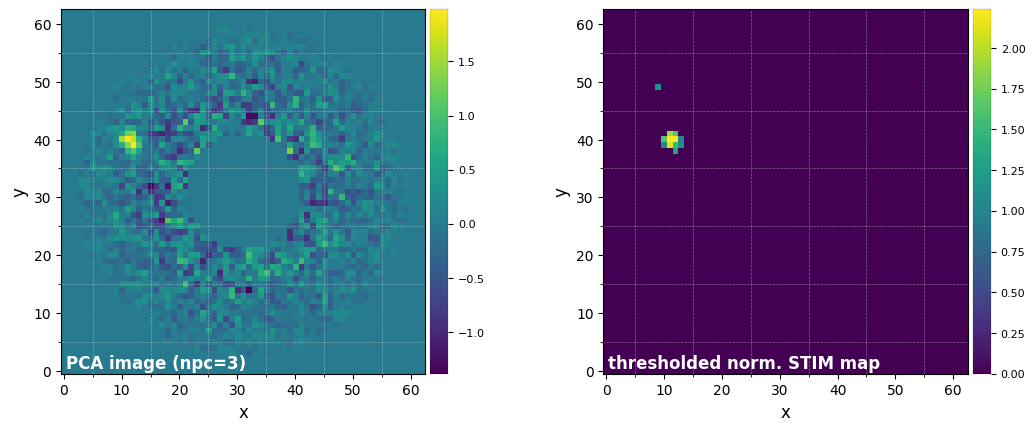

In [37]:
# threshold stim map

pl_stimmap_thr = pl_stimmap_norm.copy()
pl_stimmap_thr[np.where(pl_stimmap_thr < 1)] = 0

plot_frames((pp_cube, pl_stimmap_thr), grid=True,
            label=('PCA image (npc=%i)'%ncomp, 'thresholded norm. STIM map'))

In [86]:
# pp_cube = pca_annular(cube, angles, ncomp=ncomp)
det = detection(pp_cube, fwhm=fwhm, psf=psfn_sel_chnl, bkg_sigma=5, debug=True, mode='log', snr_thresh=5, plot=True, verbose=True)

Sigma clipped median = 0.000
Sigma clipped stddev = 0.238
Background threshold = 1.190 

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
No potential sources found
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
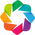

:Layout
   .Image.I  :Image   [x,y]   (z)
   .Image.II :Image   [x,y]   (z)

In [85]:
plot_frames((pp_cube, psfn_sel_chnl), backend='bokeh')

In [93]:
pl_flux

array([32.89947466])

In [96]:
# Throughput calculation
cube_pf = cube_planet_free([pl_rad, pl_theta, pl_flux], cube, angles, psfn)


# pca_emp = pca(cube_emp, angs, ncomp, verbose=True)
res_thru = throughput(cube_pf, angles, psfn, fwhm, ncomp, algo=algo, nbranch=nbranch)


TypeError: Input planet parameter with wrong dimensions.

In [ ]:
# contrast curve
# ff pca
cc_ff = contrast_curve(cube_pf, angles, psfn, fwhm, pxscale, starphot=flux_st, algo=pca, sigma=5, nbranch=nbranch, ncomp=ncomp, debug=True)

# ann pca
cc_ann = contrast_curve(cube_pf, angles, psfn, fwhm, pxscale, starphot=flux_st, algo=pca_annular, sigma=5, nbranch=nbranch, delta_rot=drot, ncomp=ncomp, radius_int=int(fwhm), debug=True)


NameError: name 'cube_pf' is not defined

In [ ]:

an_dist, comp_curve = completeness_curve(cube_pf, angles, psfn, fwhm, algo, an_dist=an_dist, pxscale=pxscale, ini_contrast=None, starphot=flux_st, plot=True, nproc=nproc, algo_dict=algo_dict)

# include completeness map?
